In [275]:
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.chrome.options import Options
from pydantic import BaseModel
from typing import Optional

import networkx as nx
import matplotlib.pyplot as plt
import uuid

class Job(BaseModel):
    href: str
    depth: int
    parent: Optional[str]

    def __hash__(self):
        return hash((self.href))

    def __eq__(self, other):
        if not isinstance(other, Job):
            return False
        return self.href == other.href


class DataScrapper():
    """
    Class given a starting url, and base url, is capable of scraping a website to N levels deep.
    """
    def __init__(self, url, base_url, max_depth):
        self.url = url
        self.base_url = base_url
        self.max_depth = max_depth
        self.reset_dependencies()
        
    def _create_driver(self):
        """
        Creates chrome web driver to grab html.
        :return: Driver
        """
        chrome_options = Options()
        chrome_options.add_argument('--headless')
        driver = webdriver.Chrome(options=chrome_options)
        return driver
    
    def get_page_html(self, url):
        """
        Using the chrome driver grabs urls html and returns it.
        
        :param url: 
        :return: 
        """
        print('getting html')
        print(url)
        self.driver.get(url)
        html = self.driver.page_source
        return html
    
    def draw_graph(self):
        """
        Used to draw a graph of the sites visited where each node is a given page and edges to new
        nodes are links from a page to a new page.
        
        :return: 
        """
        nx.draw(self.graph, with_labels=True, node_size=200, node_color='skyblue', font_size=10)
        plt.title('Data Scrapper Visual')
        plt.show()
    

    def reset_dependencies(self):
        """Reinitializes dependencies to run a new scrape job."""
        self.driver = self._create_driver()
        self.graph = nx.DiGraph()
        self.visited = set()
        
    def add_host_if_needed(self, link):
        """If link doesnt contain hostname in link we adjust it with starting hostname."""
        href = link['href']
        if not href.startswith('http'):
            href = self.url + href
        return href
    
    def add_links_to_queue(self, links, curr_job, queue, path):
        """Given a webpages links we add them to the queue list if
            1. link is within same host
            2. link hasnt been visited
            3. new link doesnt violate max depth        
        """
        for link in links:
            href = self.add_host_if_needed(link)
            print(f"base url {self.base_url} curr_job {href}")
            if (href not in self.visited and
                    self.base_url in href and
                    curr_job.depth + 1 < self.max_depth) :
                job = Job(href=href, depth=curr_job.depth + 1, parent=path)
                queue.add(job)
                
    def add_edge_to_graph(self, curr_job, path):
        """
        Add a new node to the graph.
        
        :param curr_job: 
        :param path: 
        :return: 
        """
        if curr_job.parent:
            self.graph.add_edge(curr_job.parent, path)
            
    def scrape(self, depth, parsed_documents):
        """
        We set up a starting job where to start and do a BFS search down the website iteratively.
        
        We also build a graph along the way.
        :param depth: 
        :param parsed_documents: 
        :return: 
        """
        initial_job = Job(href=self.url, depth=depth, parent=None)
        queue: set[Job] = set()
        queue.add(initial_job)
        while queue:
            curr_job = queue.pop()
            try: 
                self.visited.add(curr_job.href)
                path = uuid.uuid4().hex[:4]
                self.add_edge_to_graph(curr_job, path)
                html = self.get_page_html(curr_job.href)
                parser = BeautifulSoup(html, 'html.parser')
                parsed_documents.append({
                    "url": curr_job.href,
                    "content": parser.get_text()
                })
                links = parser.find_all('a', href=True)
                self.add_links_to_queue(links, curr_job, queue, path)
                print(f"queue {len(queue)} seen {len(self.visited)}")
                    
            except Exception as e:
                self.visited.add(curr_job.href)
                    
        

In [263]:
url = 'https://www.healthforcalifornia.com'
parsed_documents = []
base_url = 'healthforcalifornia'
scrapper = DataScrapper(url, base_url, max_depth=3)
scrapper.scrape(parsed_documents, 0)


getting html
https://www.healthforcalifornia.com
base url healthforcalifornia curr_job https://www.healthforcalifornia.com/individual-and-family-quote
base url healthforcalifornia curr_job https://www.healthforcalifornia.com/group-health-insurance
base url healthforcalifornia curr_job https://www.healthforcalifornia.com/senior-health-insurance-options
base url healthforcalifornia curr_job https://www.healthforcalifornia.com/covered-california
base url healthforcalifornia curr_job https://www.healthforcalifornia.com/covered-california/health-insurance-companies/la-care-health-plan
base url healthforcalifornia curr_job https://www.healthforcalifornia.com/covered-california/health-insurance-companies/health-net
base url healthforcalifornia curr_job https://www.healthforcalifornia.com/covered-california/health-insurance-companies/blue-shield
base url healthforcalifornia curr_job https://www.healthforcalifornia.com/covered-california/health-insurance-companies/western-health-advantage
base 

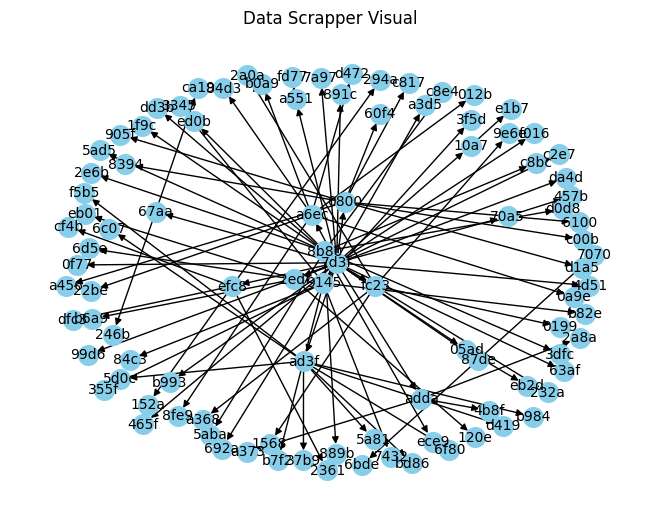

In [264]:
scrapper.draw_graph()

In [265]:
len(parsed_documents)

94

In [266]:
content_to_urls = {}

for item in parsed_documents:
    if item['content'] in content_to_urls:
        content_to_urls[item['content']].append(item['url'])
    else:
        content_to_urls[item['content']] = [item['url']]

unique_urls = set()
unique_content = set()
for item in parsed_documents:
    unique_urls.add(item['url'])
    unique_content.add(item['content'])

In [267]:
total_over_1 = 0
equal_1 = 0
for key, value in content_to_urls.items():
    
    if len(value) > 1:
        total_over_1 +=1
    elif len(value) == 1:
        equal_1 += 1
print(total_over_1)
print(equal_1)
    

5
75
0


In [268]:
parsed_documents

[{'url': 'https://www.healthforcalifornia.com',
  'content': "\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            California Health Insurance Plans | Health for California\n          \n\n\n\n\nWe're sorry but @hfc/ui-homepage doesn't work properly without JavaScript enabled.\n        Please enable it to continue.\n\nCOVERED CALIFORNIA CERTIFIEDHealth Insurancefor CaliforniaWhat type of health plan are you looking for?INDIVIDUAL & FAMILY PLANSSMALL BUSINESS PLANSMEDICARE / SENIOR PLANSLowest prices. Simple process.LEARN MORELife happens - so get covered & stay coveredThere is something for everyoneIndividual and FamilyExplore individual health insurance plans from Covered California. The vast selection of individual health insurance plans offers you the perfect coverage. Learn more Child-OnlyLearn more about California’s child-only medical plans that provide free or low-cost health insurance coverage for eligible kids and teens. Learn more MedicareShop Covered Medicare health insu

In [269]:
print(len(unique_content) == len(content_to_urls))
print(len(unique_urls))
print(len(unique_content))
# len(unique_urls)

True
94
80
